In [1]:
# --- Import libraries ---------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # vector plots

import numpy as np
import pandas as pd
import scipy.stats as spStats

import seaborn as sns
sns.set_style("whitegrid")

# --- Colors -------------------------------------------------------------------
lightgreen = "#0ACC7B"
green = "#00A35F"
red = "#E74236"
lightred = "#EE766D"
blue = "#5688C7"
lightblue = "#5688C7"

In [2]:
# --- Load data ----------------------------------------------------------------
questions = pd.read_csv('data/questions.csv')
responses = pd.read_csv('data/responsesClean.csv')
responsesBackfill = pd.read_csv('data/responsesBackfillClean.csv')

# --- Data processing ----------------------------------------------------------
# drop unused columns
questions.drop(columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', "A_ind", "B_ind", "C_ind", "D_ind", "E_ind", "F_ind", "G_ind"], inplace=True)
responses.drop(columns=['studyID', "sessionID", "userAgent"], inplace=True)
responsesBackfill.drop(columns=['studyID', "sessionID", "userAgent"], inplace=True)

responses['timestamp'] = pd.to_datetime(responses['timestamp'])
responsesBackfill['timestamp'] = pd.to_datetime(responsesBackfill['timestamp'])

In [3]:
# -- Define functions ----------------------------------------------------------

def isLoad(val):
    return isinstance(val, str) and val.startswith("load question")

def isNumeric(val):
    try:
        float(val)
        return True
    except:
        return False

In [4]:
# --- Merge Questions and Responses --------------------------------------------

# Separate load and response events
loads = responses[responses['value'].apply(isLoad)].copy()
loads = loads.rename(columns={'timestamp': 'loadTime'})

submits = responses[responses['value'].apply(isNumeric)].copy()
submits.rename(
    columns={'timestamp': 'responseTime', 'value': 'response'}, 
    inplace=True
)

# Merge load and response to compute response time
merged = pd.merge(submits, loads[['userID', 'questionNum', 'loadTime']],
    on=['userID', 'questionNum'], how='left')

merged['responseTime'] = (
    merged['responseTime'] - merged['loadTime']
).dt.total_seconds()

merged['questionID'] = (merged['userID'] - 1)*96 + merged['questionNum'] + 1
results = pd.merge(merged, questions, on='questionID', how='left')


# Compute error and correctness
results["error"] = (results['response'].astype(float) - results['selectedPart'].astype(float))
results["absError"] = results["error"].abs()
results["correct"] = results['response'].astype(float) == results['selectedPart'].astype(float)

# Add anchor and alignment binary columns
results["anchor"] = np.where(results["anchorCategory"] == "anchor", "anchor", "non-anchor")
results["alignment"] = np.where(results["alignmentCategory"] == "aligned", "aligned", "unaligned")

In [5]:
# --- Merge Questions and Responses --------------------------------------------

# Separate load and response events
loads = responsesBackfill[responsesBackfill['value'].apply(isLoad)].copy()
loads = loads.rename(columns={'timestamp': 'loadTime'})

submits = responsesBackfill[responsesBackfill['value'].apply(isNumeric)].copy()
submits.rename(
    columns={'timestamp': 'responseTime', 'value': 'response'}, 
    inplace=True
)

# Merge load and response to compute response time
merged = pd.merge(submits, loads[['userID', 'questionNum', 'loadTime']],
    on=['userID', 'questionNum'], how='left')

merged['responseTime'] = (
    merged['responseTime'] - merged['loadTime']
).dt.total_seconds()

merged['questionID'] = (merged['userID'] - 1)*96 + merged['questionNum'] + 1
resultsBackfill = pd.merge(merged, questions, on='questionID', how='left')

# Compute error and correctness
resultsBackfill["error"] = (resultsBackfill['response'].astype(float) - resultsBackfill['selectedPart'].astype(float))
resultsBackfill["absError"] = resultsBackfill["error"].abs()
resultsBackfill["correct"] = resultsBackfill['response'].astype(float) == resultsBackfill['selectedPart'].astype(float)

# Add anchor and alignment binary columns
resultsBackfill["anchor"] = np.where(resultsBackfill["anchorCategory"] == "anchor", "anchor", "non-anchor")
resultsBackfill["alignment"] = np.where(resultsBackfill["alignmentCategory"] == "aligned", "aligned", "unaligned")

In [6]:
# --- Error Exclusion Criteria -------------------------------------------------

meanError = results['absError'].mean()
medianError = results['absError'].median()
madError = spStats.median_abs_deviation(results['absError'])
stdError = results['absError'].std()
madThresholdError = medianError + 2*madError
stdThresholdError = medianError + 2*stdError

print(f"Mean Error: {meanError}")
print(f"Median Error: {medianError}")
print(f"Median Absolute Deviation: {madError}") 
print(f"Standard Deviation: {stdError}")
print(f"Threshold for MAD: {madThresholdError}")
print(f"Threshold for STD: {stdThresholdError}")

results["meanError"] = results.groupby("userID")["absError"].transform("mean")
results["excludedError"] = np.where(results["meanError"] > madThresholdError, "excluded", "included")
results["excludedResponseError"] = np.where(results["absError"] > stdThresholdError, "excludedResponse", "includedResponse")

resultsBackfill["meanError"] = resultsBackfill.groupby("userID")["absError"].transform("mean")
resultsBackfill["excludedError"] = np.where(resultsBackfill["meanError"] > madThresholdError, "excluded", "included")
resultsBackfill["excludedResponseError"] = np.where(resultsBackfill["absError"] > stdThresholdError, "excludedResponse", "includedResponse")

resultsExcludedUsers = results[results["excludedError"] == "excluded"]
backfillExcludedUsers = resultsBackfill[resultsBackfill["excludedError"] == "excluded"]
print(f"\n{resultsExcludedUsers['userID'].nunique()} users excluded from results: {resultsExcludedUsers["userID"].unique()}")
print(f"{backfillExcludedUsers['userID'].nunique()} users excluded from backfill: {backfillExcludedUsers["userID"].unique()}")

Mean Error: 5.716840277777778
Median Error: 3.0
Median Absolute Deviation: 2.0
Standard Deviation: 8.608249318416666
Threshold for MAD: 7.0
Threshold for STD: 20.216498636833332

15 users excluded from results: [ 1  3 22 23 31 48 53 50 56 55 58 59 68 82 87]
6 users excluded from backfill: [19. 41. 72. 93. 94. 95.]


In [7]:
# Response Time Exclusion Criteria
meanTime = results['responseTime'].mean()
medianTime = results['responseTime'].mean()
madTime = spStats.median_abs_deviation(results['responseTime'])
stdTime = results['responseTime'].std()
madThresholdTime = medianTime + 2*madTime
stdThresholdTime = medianTime + 2*stdTime

print(f"Mean Time: {meanTime}")
print(f"MAD Time: {madTime}")
print(f"STD Time: {stdTime}")
print(f"MAD Threshold Time: {madThresholdTime}")
print(f"STD Threshold Time: {stdThresholdTime}")

results["meanTime"] = results.groupby("userID")["responseTime"].transform("mean")
results["excludedTime"] = np.where(results["meanTime"] > madThresholdTime, "excluded", "included")
results["excludedResponseTime"] = np.where(results["responseTime"] > stdThresholdTime, "excludedResponse", "includedResponse")

resultsBackfill["meanTime"] = resultsBackfill.groupby("userID")["responseTime"].transform("mean")
resultsBackfill["excludedTime"] = np.where(resultsBackfill["meanTime"] > madThresholdTime, "excluded", "included")
resultsBackfill["excludedResponseTime"] = np.where(resultsBackfill["responseTime"] > stdThresholdTime, "excludedResponse", "includedResponse")

resultsExcludedUsers = results[results["excludedTime"] == "excluded"]
backfillExcludedUsers = resultsBackfill[resultsBackfill["excludedTime"] == "excluded"]
print(f"\n{resultsExcludedUsers['userID'].nunique()} users excluded from results: {resultsExcludedUsers["userID"].unique()}")
print(f"{backfillExcludedUsers['userID'].nunique()} users excluded from backfill: {backfillExcludedUsers["userID"].unique()}")

Mean Time: 9.549316840277779
MAD Time: 2.698
STD Time: 10.22880004802267
MAD Threshold Time: 14.94531684027778
STD Threshold Time: 30.00691693632312

8 users excluded from results: [26 27 38 40 44 59 74 81]
3 users excluded from backfill: [43. 52. 71.]


In [8]:
backfillExcluded = resultsBackfill[
    ~(resultsBackfill["excludedError"].isin(["excluded"]) | resultsBackfill["excludedTime"].isin(["excluded"]))
].copy()

resultsExcluded = results[
    ~(results["excludedError"].isin(["excluded"]) | results["excludedTime"].isin(["excluded"]))
].copy()

fullResults = pd.concat([resultsExcluded, backfillExcluded], ignore_index=True).copy()
fullResults["userID"] = fullResults["userID"].astype(int)
fullResults.drop(fullResults[fullResults["excludedResponseError"].isin(["excludedResponse"])].index, inplace=True)
fullResults.drop(fullResults[fullResults["excludedResponseTime"].isin(["excludedResponse"])].index, inplace=True)

fullResults["UID"].nunique()

60

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 14))
plt.figure(figsize=(10, 4))

for i, df in enumerate([results, resultsExcluded, fullResults]):
    sns.stripplot(
        y='absError', 
        x='userID', 
        data=df, 
        jitter=True, 
        alpha=0.5,
        hue="excludedResponseError",
        palette={"includedResponse": lightgreen, "excludedResponse": lightred},
        ax=axs[i]
    )

    sns.pointplot(
        y='absError',
        x='userID',
        data=df,
        estimator='mean',
        errorbar=None,
        hue="excludedError",
        palette={"included": green, "excluded": red},
        markers='D',
        markersize=3,
        linestyle='none',
        zorder=10,
        ax=axs[i]
    )

    axs[i].axhline(madThresholdError, color=red, linewidth=1, linestyle='-', label="MAD Threshold")
    axs[i].axhline(stdThresholdError, color=red, linewidth=1, linestyle='--', label="STD Threshold")
    axs[i].legend().remove()
    axs[i].set_ylim(-5, 80)
    axs[0].set_title("Full Sample without Exclusions")
    axs[1].set_title("With Error Exclusions")
    axs[2].set_title("Backfilled and Dropped Outliers")

fig.savefig("figs/errorExclusions.pdf", bbox_inches='tight')

<Figure size 1000x400 with 0 Axes>

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 14))
plt.figure(figsize=(10, 4))

for i, df in enumerate([results, resultsExcluded, fullResults]):
    sns.stripplot(
        y='responseTime', 
        x='userID', 
        data=df, 
        jitter=True, 
        alpha=0.5,
        hue="excludedResponseTime",
        palette={"includedResponse": lightgreen, "excludedResponse": lightred},
        ax=axs[i]
    )

    sns.pointplot(
        y='responseTime',
        x='userID',
        data=df,
        estimator='mean',
        errorbar=None,
        hue="excludedTime",
        palette={"included": green, "excluded": red},
        markers='D',
        markersize=3,
        linestyle='none',
        zorder=10,
        ax=axs[i]
    )

    axs[i].axhline(madThresholdTime, color=red, linewidth=1, linestyle='-', label="MAD Threshold")
    axs[i].axhline(stdThresholdTime, color=red, linewidth=1, linestyle='--', label="STD Threshold")
    axs[i].legend().remove()
    axs[i].set_ylim(-5, 80)
    
    axs[0].set_title("Full Sample without Exclusions")
    axs[1].set_title("With Time Exclusions")
    axs[2].set_title("Backfilled and Dropped Outliers")

fig.savefig("figs/timeExclusions.pdf", bbox_inches='tight')

<Figure size 1000x400 with 0 Axes>

In [11]:
fullResults.to_csv('data/fullResults.csv', index=False)
fullResults["userID"].nunique()

60

In [32]:
demographics = pd.read_csv('data/demographics.csv')
demographics = demographics[demographics['Participant id'].isin(fullResults['prolificID'].unique())]
demographics.drop(columns=['Total approvals', 'Participant id', 'Submission id', 'Status', 'Started at', 'Completed at', 'Reviewed at', 'Archived at', 'Time taken', 'Completion code', 'Colourblindness', 'Custom study tncs accepted at', 'Country of residence', 'Language'], inplace=True)

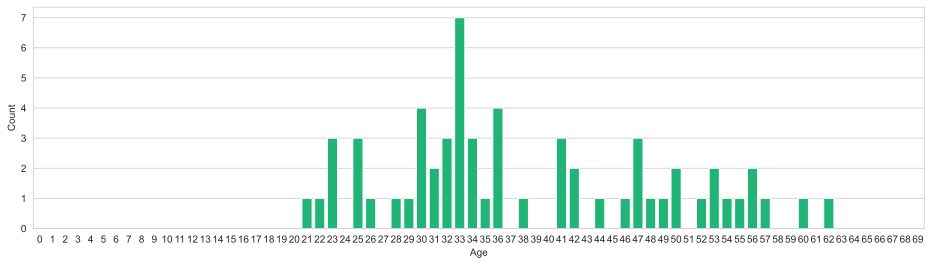

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
age = sns.countplot(data=demographics, x="Age", order=range(0, 70), color=lightgreen, ax=ax)
ax.set_ylabel("Count")
fig.savefig("figs/demographics1.pdf", bbox_inches='tight')

/var/folders/g7/k2wgq3hd4_7crzw88nqrqdv80000gn/T/ipykernel_31686/2974825603.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/g7/k2wgq3hd4_7crzw88nqrqdv80000gn/T/ipykernel_31686/2974825603.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/g7/k2wgq3hd4_7crzw88nqrqdv80000gn/T/ipykernel_31686/2974825603.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/g7/k2wgq3hd4_7crzw88nqrqdv80000gn/T/ipykernel_31686/2974825603.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

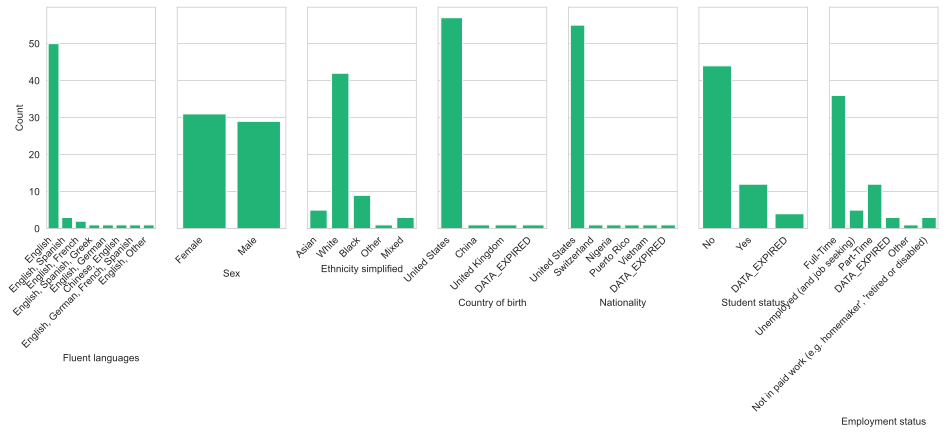

In [77]:
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(16, 4), sharey=True)
language = sns.countplot(data=demographics, x="Fluent languages", order=demographics['Fluent languages'].value_counts().index, color=lightgreen, ax=axs[0])
sex = sns.countplot(data=demographics, x="Sex", color=lightgreen, ax=axs[1])
ethnicity = sns.countplot(data=demographics, x="Ethnicity simplified", color=lightgreen, ax=axs[2])
birth = sns.countplot(data=demographics, x="Country of birth", color=lightgreen, ax=axs[3])
birth = sns.countplot(data=demographics, x="Nationality", color=lightgreen, ax=axs[4])
student = sns.countplot(data=demographics, x="Student status", color=lightgreen, ax=axs[5])
employment = sns.countplot(data=demographics, x="Employment status", color=lightgreen, ax=axs[6])

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel("Count")
fig.savefig("figs/demographics2.png", bbox_inches='tight')

/var/folders/g7/k2wgq3hd4_7crzw88nqrqdv80000gn/T/ipykernel_31686/3335263031.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/g7/k2wgq3hd4_7crzw88nqrqdv80000gn/T/ipykernel_31686/3335263031.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/g7/k2wgq3hd4_7crzw88nqrqdv80000gn/T/ipykernel_31686/3335263031.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/g7/k2wgq3hd4_7crzw88nqrqdv80000gn/T/ipykernel_31686/3335263031.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

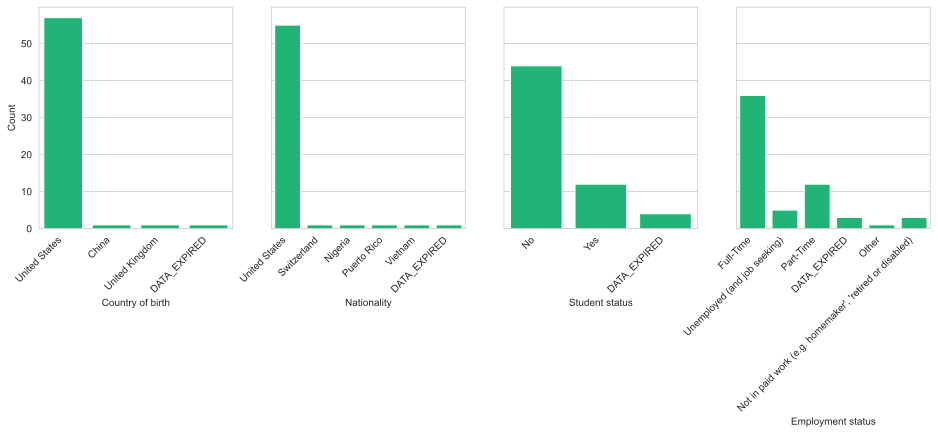

In [74]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)
birth = sns.countplot(data=demographics, x="Country of birth", color=lightgreen, ax=axs[0])
birth = sns.countplot(data=demographics, x="Nationality", color=lightgreen, ax=axs[1])
student = sns.countplot(data=demographics, x="Student status", color=lightgreen, ax=axs[2])
employment = sns.countplot(data=demographics, x="Employment status", color=lightgreen, ax=axs[3])

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel("Count")
fig.savefig("figs/demographics3.pdf", bbox_inches='tight')

In [64]:
demographics.columns

Index(['Fluent languages', 'Age', 'Sex', 'Ethnicity simplified',
       'Country of birth', 'Nationality', 'Student status',
       'Employment status'],
      dtype='object')